# Sumomo: Surrogate Modelling - Gaussian Processes

This notebook introduces Gaussian process surrogate modelling in `sumomo`.


### Imports

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
from numpy.linalg import inv, det, slogdet
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import make_moons

from sumomo import GPR, GPC, API
from utils import func_1d, peaks, plot_peaks, plot_gp

## Random variables

A random variable is a mapping from stochastic events onto the real numbers. The stochatic events cannot be predicted analytically, but can be modelled by a probability distribution and analysed statistically. For example, the Gaussian (or normal) distribution of a random variable $z$ can be specified completely by a mean $\mu$ and variance $\sigma^2$.

$$ z \sim \mathcal{N}(\mu, \sigma^2) $$

Specifying a mean and variance of 0 and 1 respectively, samples from this probability distribution realises observations of the random variable.

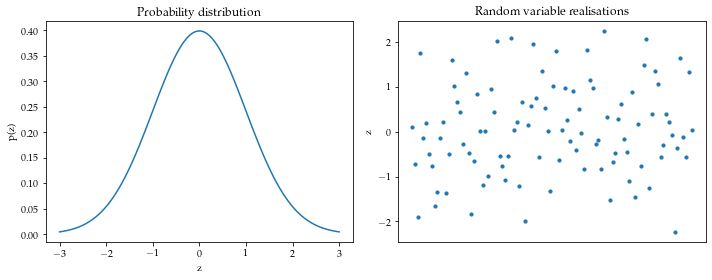

In [2]:
n = 100
mu = 0
sigma = 1
x = np.linspace(mu-3*sigma, mu+3*sigma, n)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x, stats.norm.pdf(x, mu, sigma))
ax1.set_title('Probability distribution')
ax1.set_xlabel('z')
ax1.set_ylabel('p(z)')

x = np.linspace(-5, 5, n)
f = np.random.normal(mu, sigma, n)

ax2.scatter(x, f, s=10)
ax2.set_title('Random variable realisations')
ax2.set_xticks([])
ax2.set_ylabel('z')

plt.tight_layout()
plt.show()

## Stochastic and Gaussian processes

A stochastic process is a collection of random variables that are indexed by some mathematical set. In the context of mathematical modelling, a real process $f$ can be generalised as a stochastic process wherein observations of the process $f(\textbf{x})$ are indexed by the input $\textbf{x}$. 

The randomness of stochastic processes is also modelled with probability distributions. However, the power of modelling stochastic processes lies in the generalisation of these probability distributions to functions. In the case that the process is assumed Gaussian, this is achieved by defining a mean *function* and covariance *function* wherein the mean and variance of the stochastic process *outputs* are written as functions of the *inputs*.

$$ \mathbb{E}[ f(\textbf{x}) ] = \mu(\textbf{x}) $$
$$ \text{cov}[ f(\textbf{x}), f(\textbf{x}') ] = k(\textbf{x}, \textbf{x}') $$

The result is a joint probability distribution over an effectively infinite number of functions which share the same mean function and covariance function. Written in this general way, $f(\textbf{x})$ is a single realised function from the distribution, $\textbf{x}$ represents effectively infinite samples in the input domain, $\mu(\textbf{x})$ is the mean function evaluated over this domain, and $k(\textbf{x}, \textbf{x}')$ is the covariance matrix evaluated at all possible pairs in the input domain.

$$f(\textbf{x}) \sim \mathcal{N}\left(\mu(\textbf{x}), k(\textbf{x} \:,\: \textbf{x}')\right)$$

Practically, it is not possible to sample over an infinite input domain to obtain entire function evaluations. To this end, it is practical to define a finite number of inputs $X$ and evaluate a mean vector $\boldsymbol{\mu} = \mu(X)$ and covariance matrix $K = k(X, X)$. Finally, a random Gaussian vector can be generated from this marginal distribution.

$$\textbf{f} \sim \mathcal{N}\left(\boldsymbol{\mu}, K\right)$$

Modelling stochastic processes in this way, where the process is assumed Gaussian, enables relatively simple computations for supervised machine learning and Bayesian inference. As a result *Gaussian processes* have gained much traction in this area over the past decades.

## Prior distribution

The prior distribution is specified by defining the mean function and covariance function of the Gaussian distribution.

Specifying the covariance function enables users to incorporate expert knowledge into the model, for example favouring smooth, periodic, or noisy functions. In this case, the squared exponential covariance function is used, where $\sigma^2_f$ and $l$ are a postive function variance parameter and characteristic length scale, respectively. The length scale represents the sensitivty of the function, where higher values ensure that even two points far away are correlated resluting in an overall smoothing effect, whilst lower values result in higher frequency function changes. Note that the length scale appears as $l^2$ in the equation as it has been taken outside of the squared distance term, although it could also be written as $ \left|\frac{x_j - x'_j}{l}\right|^2 $. This covariance function can be evaluated between two points $\textbf{x}, \textbf{x}'$ in $m$-dimensional space, such that $x_j, x'_j$ represent coordinates for $j=1, ... m$.

$$ k(\textbf{x}, \textbf{x}') = \sigma^2_f\exp\left( - \frac{1}{2l^2} \sum_{j=1}^m \left|x_j - x'_j\right|^2 \right) $$

In [3]:
def cov(x1, x2, sigma_f=1.0, l=1.0):
    sq_dist = sum((x1[:, j].reshape(1, -1) - x2[:, j].reshape(-1, 1)) ** 2 for j in range(x1.shape[1]))
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * sq_dist)

The mean function is typically assumed to be a constant or zero since modelling the covariances in this way is sufficient to capture the overall model behaviour. Commonly, a zero mean function is used since the training data has typically been standardised before training the model, such that the true mean is in fact zero itself.

Once the mean function and covariance functions have been specified, it is possible to evaluate the Gaussian prior over a finite number of inputs $X$. The result is different function realisations over the finite domain, where each of these functions shares the mean function and covariance function of the Gaussian prior. In this case, the distribution of functions has a mean of 0 and a variance of 1, where the plot shows 1.96 times the standard deviation as the 95 % confidence interval for normally distributed data. Also plotted is the covariance function evaluated between 0 and $X$.

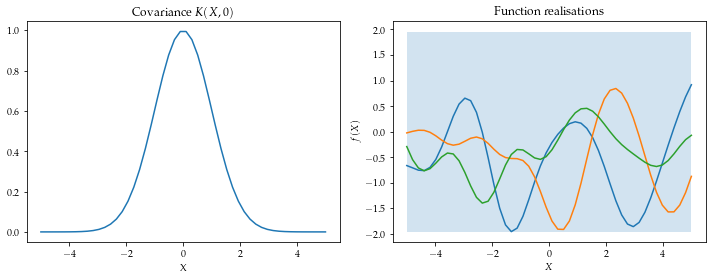

In [4]:
n_functions = 3
x = np.linspace(-5, 5, 50).reshape(-1, 1)
mu = np.zeros(len(x))
k = cov(x, x)
std = np.sqrt(np.diag(k))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x, cov(np.array([[0]]), x))
ax1.set_title('Covariance $K(X, 0)$')
ax1.set_xlabel('X')

ax2.fill_between(x.ravel(), mu + 1.96 * std, mu - 1.96 * std, alpha=0.2)
for i in range(n_functions):
    fn = np.random.multivariate_normal(mu, k)
    ax2.plot(x, fn)
ax2.set_title('Function realisations')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$f(X)$')

plt.tight_layout()
plt.show()

## Gaussian process regression

Given a set of training observations $\textbf{f}$ made over training inputs $X$, and a single testing input $\textbf{x}_*$, the joint distribution with the unknown testing output $f_*$ according to the Gaussian prior is given below. 

$$ \begin{bmatrix} \textbf{f}\\ f_* \end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \boldsymbol{\mu}\\ \mu \end{bmatrix} , \begin{bmatrix} k(X, X) & k(X, \textbf{x}_*)\\ k(X, \textbf{x}_*) & k(\textbf{x}_*, \textbf{x}_*) \end{bmatrix} \right) $$

To simplify the notation, $\textbf{k}_*$ can be written the $n$-vector of covariances between the single testing input and $n$ training samples, the covariance between the new input and itself $k(\textbf{x}_*, \textbf{x}_*)$ is equal to the process variance $\sigma^2_f$, and the notation $K = k(X, X)$ can also be reused here.

$$ \begin{bmatrix} \textbf{f}\\ f_* \end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \boldsymbol{\mu}\\ \mu \end{bmatrix} , \begin{bmatrix} K & \textbf{k}_*\\ \textbf{k}_*^T & \sigma_f^2 \end{bmatrix} \right) $$

### Conditioning

Consider random vectors $\textbf{p}$ and $\textbf{q}$ with the joint Gaussian distribution given below.

$$ \begin{bmatrix} \textbf{p}\\ \textbf{q} \end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \boldsymbol{\mu}_p\\ \boldsymbol{\mu}_q \end{bmatrix} \; , \; \begin{bmatrix} A & C\\ C^T & B \end{bmatrix} \right) $$

The conditional distribution of $\textbf{p}$ given $\textbf{q}$ can be written as below.

$$ \textbf{p} \mid \textbf{q} \sim \mathcal{N} \left( \boldsymbol{\mu}_p + C B^{-1}(\textbf{q} - \boldsymbol{\mu}_q) , A - C B ^{-1} C^T \right) $$

### Posterior distribution and predictions

The posterior distribution is obtained by conditioning the joint Gaussian prior distribution on the observations. In the case of Gaussian process regression, the posterior mean and covariance functions can be evaluated at the single testing input and written as below. Practically, the mean function can be used as a predictive model, whilst the covariance function provides an estimate of the uncertainty in these predictions. In the case that the prior mean function is assumed equal to zero, the predictive mean function can be further simplifed as shown.

$$ 
\begin{align}
\bar{f_*} & = \mu + \textbf{k}_*^T K^{-1}(\textbf{f} - \boldsymbol{\mu}) & \\
& = \textbf{k}_*^T K^{-1}\textbf{f} & \text{for} \; \mu = 0 \; (\text{and} \; \boldsymbol{\mu} = \textbf{0})\\
\mathbb{V}\left[{f_*}\right] & = \sigma^2_f - \textbf{k}_*^T K^{-1}\textbf{k}_* & \\
\end{align}
$$

In [5]:
def posterior(X, f, x, sigma_f=1.0, l=1.0, sigma_n=0.0):
    K = cov(X, X, sigma_f, l) + sigma_n * np.eye(len(X))
    k = cov(x, X, sigma_f, l)
    
    mean = k.T @ inv(K) @ f
    var = cov(x, x, sigma_f, l) - k.T @ inv(K) @ k #+ np.eye(len(x)) * sigma_n
    
    return mean.ravel(), var

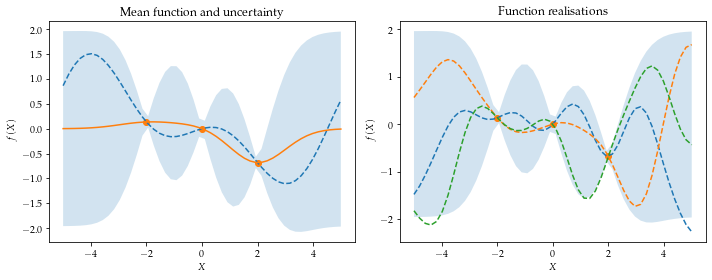

In [6]:
n_samples = 5
n_functions = 3
X = np.linspace(-2, 2, 3).reshape(-1, 1)
f = func_1d(X)
x = np.linspace(-5, 5, 50).reshape(-1, 1)
f_true = func_1d(x)

mean, var = posterior(X, f, x)
std = np.sqrt(np.diag(var))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x, f_true, '--')
ax1.plot(x, mean)
ax1.fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
ax1.scatter(X, f)
ax1.set_title('Mean function and uncertainty')
ax1.set_xlabel('$X$')
ax1.set_ylabel('$f(X)$')

for i in range(n_functions):
    fn = np.random.multivariate_normal(mean, var)
    ax2.plot(x, fn, '--')
ax2.fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
ax2.scatter(X, f)
ax2.set_title('Function realisations')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$f(X)$')

plt.tight_layout()
plt.show()

### Varying the hyperparameters

The hyperparameters $\sigma_f^2$ and $l$ can be varied to obtain tuned function behaviour.

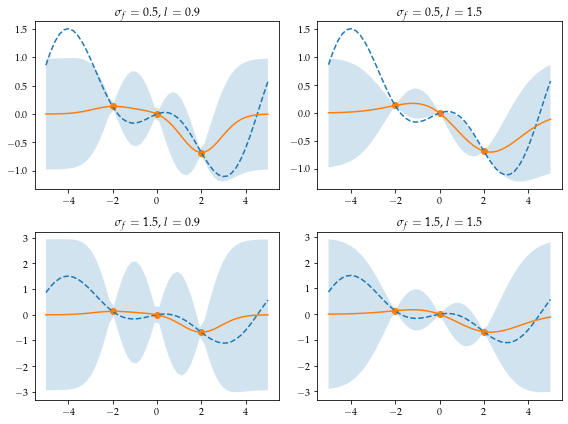

In [7]:
sigma_f = [0.5, 1.5]
l = [0.9, 1.5]

fig, axs = plt.subplots(2, 2, figsize=(8,6))

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        mean, var = posterior(X, f, x, sigma_f[i], l[j])
        std = np.sqrt(np.diag(var))

        axs[i, j].plot(x, f_true, '--')
        axs[i, j].plot(x, mean)
        axs[i, j].fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
        axs[i, j].scatter(X, f)
        axs[i, j].title.set_text('$\sigma_f={}$,  $l={}$'.format(sigma_f[i], l[j]))

plt.tight_layout()
plt.show()

### Optimising the hyperparameters

In the case of parameterised covariance functions (also known as kernels), the hyperparamters can be optimised to maximise some measure of the function fit. Specifically, Maximum Likelihood Estimation can be used to maximise the log marginal likelihood function (or, more accurately, minimise the negative log marginal likelihood), where the first term $\frac{1}{2} \textbf{f}^T K^{-1} \textbf{f}$ is the data-fit based on observed data, the middle term $\frac{1}{2} \log \left| K \right|$ is a complexity penalty, and the thrid term $\frac{n}{2} \log (2\pi)$ is a normalisation constant.

$$ \min \frac{1}{2} \textbf{f}^T K^{-1} \textbf{f} + \frac{1}{2} \log \left| K \right| + \frac{n}{2} \log (2\pi) $$

The Sumomo `GPR` class inherits from the `GaussianProcessRegressor` from *scikit-learn*. Specifically, `GPR` is initialised with the an optional `noise` attribute with default value equal to 0. Additionally, `GPR` is initialised with the squared exponential kernel also known as the radial basis function `RBF` kernel from *scikit-learn*, with an initial `length_scale` equal to 1 and `length_scale_bounds` at (0, 100). The `1.0` pre-factor to `RBF` provides a kernel scaling paramter equivalent to $\sigma_f^2$.

In [8]:
def opt_fun(X, f):
    def nll(theta):
        K = cov(X, X, theta[0], theta[1]) + theta[2] * np.eye(len(X))
        fn = 0.5 * f.T.dot(inv(K).dot(f)) + 0.5 * np.log(det(K)) + 0.5 * len(X) * np.log(2 * np.pi)
        return fn
    return nll

res = minimize(opt_fun(X, f), [1, 1, 0], bounds=((1e-5, None), (1e-5, None), (1e-5, None)), method='L-BFGS-B')

print('Optimised parameters')
print('{:8} {:<8.5f}\n{:8} {:<8.5f}\n{:8} {:<8.5f}\n{:8} {:<8.5f}'.format(
    'sigma_f', res.x[0], 'l', res.x[1], 'sigma_n', res.x[2], 'fun', res.fun))

Optimised parameters
sigma_f  0.40499 
l        1.07610 
sigma_n  0.00001 
fun      1.51262 


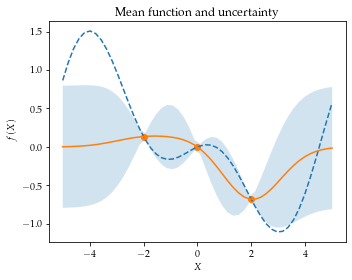

In [9]:
mean, var = posterior(X, f, x, *res.x)
std = np.sqrt(np.diag(var))

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x, f_true, '--')
ax.plot(x, mean)
ax.fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
ax.scatter(X, f)
ax.set_title('Mean function and uncertainty')
ax.set_xlabel('$X$')
ax.set_ylabel('$f(X)$')

plt.tight_layout()

### Predictions with noisy observations

In the case of noisy observations where $\textbf{y} = \textbf{f} + \epsilon$, this noise can be incorporated into the covariance function by adding an additional variance due to noise term $\sigma^2_n$ to the diagonal.

$$ K_y = K + \sigma^2_n I $$

The corresponding joint distrubtion between noisy observations and a noisy prediction can be written as below, where $\sigma^2_n$ is also added to the variance in the predictions.

$$ \begin{align} \begin{bmatrix} \textbf{y}\\ y_* \end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \textbf{0}\\ 0 \end{bmatrix} , \begin{bmatrix} K + \sigma^2_n I & \textbf{k}_*\\ \textbf{k}^T_* & \sigma^2_f + \sigma^2_n \end{bmatrix} \right) \end{align}$$

The resulting predictive mean function and variance function provide a more generalised version with an optional noise parameter.

$$ \bar{y_*} = \textbf{k}_*^T (K + \sigma^2_n I)^{-1}\textbf{y} $$

$$ \mathbb{V}\left[{y_*}\right] = \sigma^2_f + \sigma^2_n - \textbf{k}_*^T (K + \sigma^2_n I)^{-1}\textbf{k}_* $$

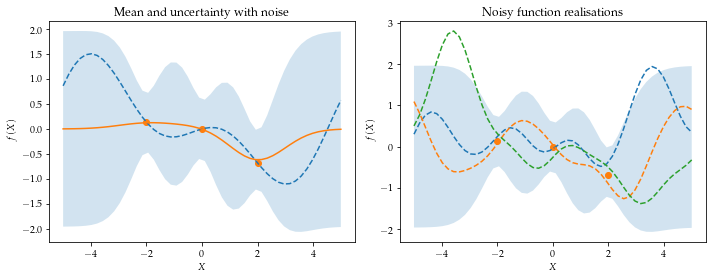

In [10]:
noise = 0.1
mean, var = posterior(X, f, x, sigma_n=noise)
std = np.sqrt(np.diag(var))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(x, f_true, '--')
ax1.plot(x, mean)
ax1.fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
ax1.scatter(X, f)
ax1.set_title('Mean and uncertainty with noise')
ax1.set_xlabel('$X$')
ax1.set_ylabel('$f(X)$')

for i in range(n_functions):
    fn = np.random.multivariate_normal(mean, var)
    ax2.plot(x, fn, '--')
ax2.fill_between(x.ravel(), mean + 1.96 * std, mean - 1.96 * std, alpha=0.2)
ax2.scatter(X, f)
ax2.set_title('Noisy function realisations')
ax2.set_xlabel('$X$')
ax2.set_ylabel('$f(X)$')

plt.tight_layout()
plt.show()

### Linear predictor and NumPy formulations

Since $(K + \sigma^2_n I)^{-1}\textbf{y}$ is only a function of the training data, only $\textbf{k}_*^T$ in the predictive mean functions depends on new inputs enabling the linear predictor to be written as below, where $\boldsymbol{\alpha} = (K + \sigma^2_n I)^{-1}\textbf{y}$.

$$ \bar{y}(\textbf{x}_*) = \sum_i^n \alpha_i k(X_i, \textbf{x}_* ) $$

This formulation is implemented in the Gaussian process regressor `formulation` method used in `sumomo`. The table below shows the agreement between the GPR `predict` method which implements the mean function formulation directly, the GPR `formulation` method which implements a *NumPy* formulation using summation notation inplace of matrix operations comparable to formulations necessitated by optimisation solvers in *Pyomo*, and the `posterior` method coded in this notebook.

In [11]:
x_new = np.array(0.420).reshape(-1, 1)
print('{:16} {:16} {:16}'.format('', 'mean', 'std'))

# GPR predict()
gpr = GPR()
gpr.fit(X, f)
p, s = gpr.predict(x_new, return_std=True)
print('{:16} {:<16.8f} {:<16.8f}'.format('GPR predict', p.ravel()[0], s[0]))

# GPR formulation()
pred, sig = gpr.formulation(x_new, return_std=True)
print('{:16} {:<16.8f} {:<16.8f}'.format('GPR formulation', pred[0], sig[0]))

# posterior()
prediction, var = posterior(X, f, x_new, np.sqrt(gpr.constant_value), gpr.length_scale, np.sqrt(gpr.noise))
std = np.sqrt(np.diag(var))
print('{:16} {:<16.8f} {:<16.8f}'.format('posterior', prediction[0], std[0]))

                 mean             std             
GPR predict      -0.13299577      0.12959739      
GPR formulation  -0.13299577      0.12959739      
posterior        -0.13299577      0.12959739      


/Users/alexdurkin/miniconda3/envs/sumomo-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


## Gaussian process classification

### Binary classification

Binary classification problems differ from regression problems in the following ways:

* The training targets for binary classification are binary class labels $\{0, 1\}$ or $\{-1, 1\}$, as opposed to continuous outputs in $\mathbb{R}$ used in regression.
* Similarly, predictions must be interpretable as either binary class labels or probabilities, in the range $[0, 1]$, that the target belongs to class 1, as opposed to continuous predictions in $\mathbb{R}$.

### Laplace approximation
The Laplace approximation approximates a non-Gaussian distribution $p(z) = \frac{1}{Z} f(z)$ (where $Z=\int f(z)\;dz$ is the normalisation coefficient) with a Gaussian distribution centered at the mode $z_0$. The mode is the most common realisation of $z$ or a maximum stationary point on $p(z)$ such that the below equation is satisfied.

$$ \left. \nabla f(z) \right|_{z=z_0} = 0 $$

By assuming a Gaussian approximation, the logarithm can be written as a quadratic function of the variables. A Taylor expansion of $\text{ln} f(z)$, centred on the mode $z_0$ can then be written as below, where $H=\left. -\nabla\nabla\text{ln}f(z) \right|_{z=z_0}$ is the Hessian of the negative log posterior at the mode.

$$ \text{ln} f(z) \approx \text{ln} f(z_0) - \frac{1}{2} H (z - z_0)^2 $$

Taking the exponential of the above function then yields the function below.

$$ f(z) \approx f(z_0) \exp \left( - \frac{H}{2} (z - z_0)^2\right) $$

The normalised Gaussian distribution can then be written as below, with mean at the posterior mode $z_0$ and covariance given by the inverse Hessian.

$$ q(z) = \left( \frac{H}{2\pi} \right)^{1/2} \exp \left( - \frac{H}{2} (z - z_0)^2\right) = \mathcal{N} \left( z_0, H^{-1} \right) $$

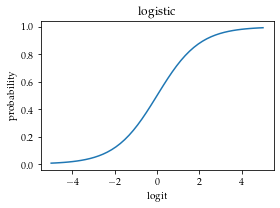

In [12]:
def logistic(x):
    return 1 / ( 1 + np.exp(-x) )

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, logistic(x))
ax.title.set_text('logistic')
ax.set_xlabel('logit')
ax.set_ylabel('probability')

plt.tight_layout()

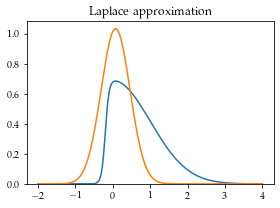

In [13]:
def non_gaussian(x):
    return np.exp( - x ** 2 / 2) * logistic(20 * x + 4)

def d2df2(x):
    return 1 + 400 * np.exp(20 * x + 4) / (np.exp(20 * x + 4) + 1) ** 2

min_val = -2
max_val = 4
n_bins = 1000

z = np.linspace(min_val, max_val, n_bins+1)
p_z = non_gaussian(z)
area = sum(p_z) * (max_val - min_val) / n_bins
mode = z[np.argmax(p_z)]
norm_p = p_z / area

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(z, norm_p)
ax.plot(z, stats.norm.pdf(z, mode, 1 / d2df2(mode)))
ax.set_ylim((0, None))
ax.title.set_text('Laplace approximation')

plt.tight_layout()

### Gaussian processes for binary classification

Gaussian processes for binary classification problems are based on the fundamental idea: place a GP prior over a *latent* function $a(\textbf{x})$ and then "squash" this through the logistic (sigmoid) function to obtain a prior with outputs that are constrained between 0 and 1 and therefore interpretable as a probabilities. The predictive probability distribution can be written as below, where $p(t_*=1 \mid a_*)$ has been substituted with $\sigma(a_*)$ where $\sigma(\cdot)$ is the sigmoid function.

$$ p(t_*=1 \mid \textbf{t}) = \int \sigma(a_*) p(a_* \mid \textbf{t}) \, da_* $$

Since the latent function $f_*$ is assumed Gaussian, the distribution $p(a_* \mid \textbf{t})$ can be written as below.

$$ p(a_* \mid \textbf{t}) = \int p(a_* \mid \textbf{a}) p(\textbf{a} \mid \textbf{t}) \, d\textbf{a} $$

Here, the first term in the integral follows a Gaussian distribution, obtained using Gaussian process regression, with mean and variance functions.

Due to the targets $\textbf{t}$ following a Bernoulli distribution, the non-Gaussian likelihood $p(\textbf{a} \mid \textbf{t})$ must be approximated as Gaussian using the Laplace approximation as shown below, where $\hat{\textbf{a}}$ is the posterior mode, and $H^{-1}$ is the inverse Hessian matrix of the negative log posterior at that point.

$$p(\textbf{a} \mid \textbf{t}) \approx \mathcal{N}\left( \hat{\textbf{a}}, H^{-1} \right)$$

The Hessian matrix can be evaluated as below.

$$ \text{ln} p(\textbf{f}, X) = -\frac{1}{2}\textbf{f}^T K^{-1}\textbf{f} - \frac{1}{2} \text{ln} \left|{K}\right| - \frac{n}{2} \text{ln}(2\pi) $$

$$ H=\left. -\nabla\nabla\text{ln}f(z) \right|_{z=z_0} = - \nabla\nabla \text{ln} p(\textbf{f}, X) + K^{-1} = W + K^{-1} $$

In the above equation $W = - \nabla\nabla \text{ln} p(\textbf{f}, X)$ is a diagonal matrix with elements $\sigma(a_i)(1-\sigma(a_i))$ where $a_i$ are the elements of $n$-vector $\textbf{a}$.

The posterior mode $\hat{\textbf{a}}$ can be determined numerically using the update equation below.

$$ \textbf{a} = K(I + WK)^{-1}(\textbf{t} - \boldsymbol{\sigma} + W \textbf{a}) $$

In [14]:
def posterior_mode(X, t, sigma_f, l, max_iter=10, tol=1e-9):
    K = cov(X, X, sigma_f, l)
    a = np.zeros_like(t)
    I = np.eye(X.shape[0])
    for i in range(max_iter):
        W = logistic(a) * (1 - logistic(a))
        W = np.diag(W.ravel())
        inv_Q = inv(I + W @ K)
        a_new = (K @ inv_Q).dot(t - logistic(a) + W.dot(a))
        a_diff = np.abs(a_new - a)
        a = a_new
        if not np.any(a_diff > tol):
            break
    return a

With two Gaussians in the integral, the Gaussian approximation of $p(a_* \mid \textbf{t})$ can be determined analytical with mean and variance shown below.

$$ p(a_* \mid \textbf{t}) \approx \mathcal{N} \left( \textbf{k}_*^T (\textbf{t} - \boldsymbol{\sigma}) \:,\: k_{**} - \textbf{k}_*^T(W^{-1} + K)^{-1}\textbf{k}_* \right) $$

Finally, $\sigma(a_*)$ is approximated with the inverse probit function such that the final predictive distribution can be approximated with the below function.

$$ p(t_*=1 \mid \textbf{t}) \approx \sigma\left( \textbf{k}_*^T (\textbf{t} - \boldsymbol{\sigma}) \left( 1 + \frac{\pi}{8} \left( k_{**} - \textbf{k}_*^T(W^{-1} + K)^{-1}\textbf{k}_* \right) \right)^{-1/2} \right) $$

In [15]:
def fit(X, t):
    def opt_fun(theta):
        I = np.eye(X.shape[0])
        sigma_f, l = theta[0], theta[1]
        K = cov(X, X, sigma_f, l) + 1e-5 * I
        inv_K = inv(K)
        a = posterior_mode(X, t, sigma_f, l)
        W = logistic(a) * (1 - logistic(a))
        W = np.diag(W.ravel())
        ll = t.T.dot(a) - np.sum(np.log(1.0 + np.exp(a))) - 0.5 * (
            a.T.dot(inv_K).dot(a) + 
            slogdet(K)[1] + 
            slogdet(W+inv_K)[1])
        return -ll
    
    params = minimize(opt_fun, 
                      x0=[1.0, 1.0], 
                      bounds=[(1e-6, None), (1e-6, None)], 
                      method='L-BFGS-B', 
                      options={'iprint': -1})
    
    sigma_f, l = params.x[0], params.x[1]
    a = posterior_mode(X, t, sigma_f, l)
    W = logistic(a) * (1 - logistic(a))
    W = np.diag(W.ravel())
    K = cov(X, X, sigma_f, l)
    P = inv(W) + K
    inv_P = inv(P)
    delta = t - logistic(a)
    
    gpc_params = [sigma_f, l, a, inv_P, delta]
    
    return gpc_params

In [16]:
def predict(x, sigma_f, l, a, inv_P, delta, return_std=False):
    a = posterior_mode(X, t, sigma_f, l)
    k = cov(x, X, sigma_f, l)
    mu = k.T.dot(t - logistic(a))
    var = sigma_f ** 2 - k.T.dot(inv_P).dot(k)
    var = np.diag(var).clip(min=0).reshape(-1, 1)
    beta = np.sqrt(1 + 3.1416 / 8 * var)
    prediction = logistic(mu / beta)
    if return_std:
        return prediction, np.sqrt(var)
    else:
        return prediction

In [17]:
X, t = make_moons(50, noise=0.3)
t = t.reshape(-1, 1)
x = np.array([[0.0, 0.0]])

print('{:10} {:12} {:12} {:12}'.format('', 'sigma_f', 'l', 'prediction'))

params = fit(X, t)
pred = predict(x, *params)
print('{:10} {:<12.8f} {:<12.8f} {:<12.8f}'.format('notebook', params[0], params[1], pred.ravel()[0]))

gpc = GPC()
gpc.fit(X, t)
gpc_pred = gpc.predict(x)
print('{:10} {:<12.8f} {:<12.8f} {:<12.8f}'.format('GPC', gpc.sigma_f, gpc.l, gpc_pred.ravel()[0]))

           sigma_f      l            prediction  
notebook   9.63219646   0.72827426   0.93207349  
GPC        9.63219646   0.72827426   0.93207349  


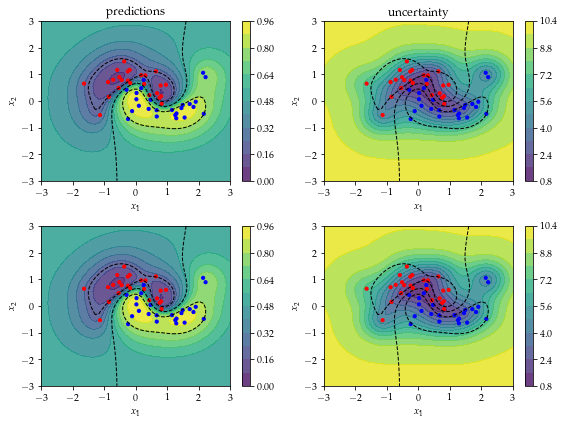

In [18]:
x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]

p, s = predict(x_new, *params, return_std=True)
p = p.reshape(x1grid.shape)
s = s.reshape(x1grid.shape)

gpc_p, gpc_s = gpc.predict(x_new, return_std=True)
gpc_p = gpc_p.reshape(x1grid.shape)
gpc_s = gpc_s.reshape(x1grid.shape)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,6))
c1 = ax1.contourf(x1, x2, p, levels=12, alpha=0.8)
ax1.scatter(X[:, 0], X[:, 1], s=10, c=t, cmap='bwr_r')
ax1.contour(x1, x2, p, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.title.set_text('predictions')
fig.colorbar(c1, ax=ax1)

c2 = ax2.contourf(x1, x2, s, levels=12, alpha=0.8)
ax2.scatter(X[:, 0], X[:, 1], s=10, c=t, cmap='bwr_r')
ax2.contour(x1, x2, p, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.title.set_text('uncertainty')
fig.colorbar(c2, ax=ax2)

c3 = ax3.contourf(x1, x2, gpc_p, levels=12, alpha=0.8)
ax3.scatter(X[:, 0], X[:, 1], s=10, c=t, cmap='bwr_r')
ax3.contour(x1, x2, gpc_p, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
fig.colorbar(c3, ax=ax3)

c4 = ax4.contourf(x1, x2, gpc_s, levels=12, alpha=0.8)
ax4.scatter(X[:, 0], X[:, 1], s=10, c=t, cmap='bwr_r')
ax4.contour(x1, x2, gpc_p, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$x_2$')
fig.colorbar(c4, ax=ax4)

plt.tight_layout()

### NumPy formulations

Write about NumPy formulations e.g. saving parameters during fitting then formulate at predict...

In [19]:
# NumPy formulations

## Simultaneous regression and classification

### 1-dimensional example



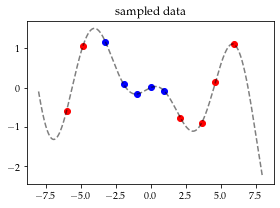

In [20]:
space = [(-6.0, 6.0)]
n_samples = 11

api = API(n_samples, space)

y_train = func_1d(api.x)
t = np.ones_like(api.x)
t[api.x < -4] = 0
t[api.x > 2] = 0
t = t.reshape(-1, 1)
x_new = np.arange(-8, 8, 0.01).reshape(-1, 1)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, func_1d(x_new), ls='--', alpha=0.5, c='k')
ax.title.set_text('sampled data')
ax.scatter(api.x[t.ravel()==1, :], y_train[t.ravel()==1], c='b')
ax.scatter(api.x[t.ravel()==0, :], y_train[t.ravel()==0], c='r')

plt.tight_layout()

/Users/alexdurkin/miniconda3/envs/sumomo-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


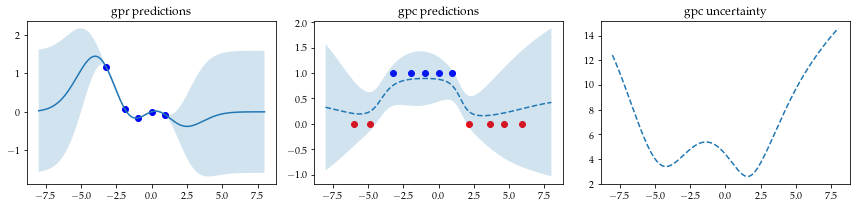

In [21]:
gpr = GPR()
gpr.fit(api.x[t.ravel()==1, :], y_train[t.ravel()==1])

gpc = GPC()
gpc.fit(api.x, t)

pred, std = gpr.predict(x_new, return_std=True)
un = 1.96 * std
f, s = gpc.predict(x_new, return_std=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
ax1.plot(x_new, pred)
# ax1.plot(x_new, func_1d(x_new), ls='--', alpha=0.5, c='k')
ax1.title.set_text('gpr predictions')
ax1.fill_between(x_new.ravel(), pred.ravel() + un.ravel(), pred.ravel() - un.ravel(), alpha=0.2)
ax1.scatter(api.x[t.ravel()==1, :], y_train[t.ravel()==1], c='b')
# ax1.scatter(api.x[t.ravel()==0, :], y_train[t.ravel()==0], c='r')

ax2.plot(x_new, f, ls='--')
ax2.scatter(api.x[t==1], t[t==1], c='b')
ax2.scatter(api.x[t==0], t[t==0], c='r')
ax2.fill_between(x_new.ravel(), f.ravel() + s.ravel()/10, f.ravel() - s.ravel()/10, alpha=0.2)
ax2.title.set_text('gpc predictions')

ax3.plot(x_new, s, ls='--')
ax3.title.set_text('gpc uncertainty')

plt.tight_layout()

### 2-dimensional example

$$ f(x) = 3(1-x_0)^2 \exp\left(-x_0^2 - (x_1 + 1)^2\right) - 10 \left(\frac{x_0}{5} - x_0^3 - x_1^5\right)\exp\left(-x_0^2 - x_1^2\right) - \frac{1}{3}\exp\left(-(x_0+1)^2 - x_1^2\right) $$

[-6.52589168] [8.04358645]


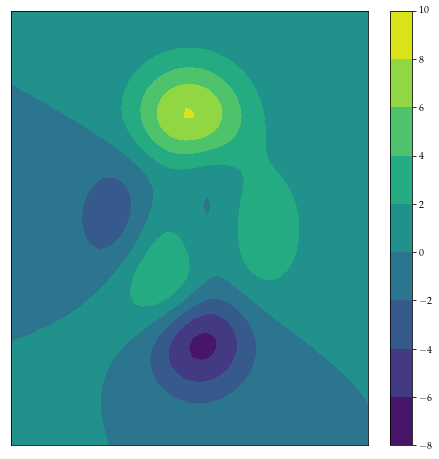

In [22]:
plot_peaks()

Initialise the sampling strategy with 100 samples bounded in two dimensions between (-3.0, 3.0) with 1 output variable using Latin hypercube sampling. Sample the output data from the peaks function. Split the data into training (70 samples) and testing sets (30 samples). Standardise the data accordingly.

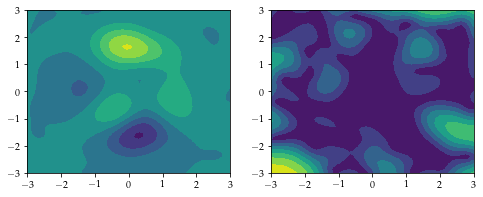

In [23]:
api = API(100, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')

api.y = peaks(api.x)

for i in range(api.x.shape[0]):
    if ( api.x[i, 0] ** 2 + api.x[i, 1] ** 2 > 4 ):
        api.t[i] = 0

# print(api.t)

api.split(test_size=0.3)
api.scale()

api.init_regressor('gp', noise=0.0)

with np.errstate(divide='ignore'):
    api.regressor.fit(api.x_train_, api.y_train_)

plot_gp(api, show_samples=False)

[-6.22164942] [8.15033102]
(2500, 2) (2500, 1)


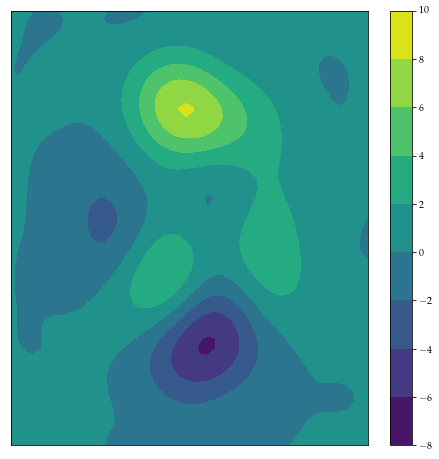

In [24]:
# get plotting data
x1_scaled, x2_scaled = np.linspace(*api.space_[0], 50), np.linspace(*api.space_[1], 50)
x1_scaled_grid, x2_scaled_grid = np.meshgrid(x1_scaled, x2_scaled)
model_input_grid = np.c_[x1_scaled_grid.ravel(), x2_scaled_grid.ravel()]
pred_grid, u_grid = api.regressor.predict(model_input_grid, return_std=True)

# rescale
if api.x_train is not None:
    x_plot = np.c_[x1_scaled, x2_scaled] * api.x_train_std + api.x_train_mean
    pred_plot = pred_grid * api.y_train_std + api.y_train_mean
    u_plot = u_grid * api.y_train_std
else:
    x_plot = np.c_[x1_scaled, x2_scaled] * api.x_std + api.x_mean
    pred_plot = pred_grid * api.y_std + api.y_mean
    u_plot = u_grid * api.y_std

print(min(pred_plot), max(pred_plot))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
c = ax.contourf(x_plot[:, 0], x_plot[:, 1], pred_plot.reshape((50, 50)))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('gpr', bbox_inches='tight', pad_inches=-0.1)

fig.colorbar(c, ax=ax)

x1_to_save, x2_to_save = np.linspace(*api.space[0], 50), np.linspace(*api.space[1], 50)
x1_to_save_grid, x2_to_save_grid = np.meshgrid(x1_to_save, x2_to_save)
x_to_save = np.c_[x1_to_save_grid.ravel(), x2_to_save_grid.ravel()]
print(x_to_save.shape, pred_plot.shape)

headers = 'x1,x2'
np.savetxt('gpr-xtrain.csv', api.x_train, header=headers, delimiter=',', comments='')
np.savetxt('gpr-xtest.csv', api.x_test, header=headers, delimiter=',', comments='')

plt.show()

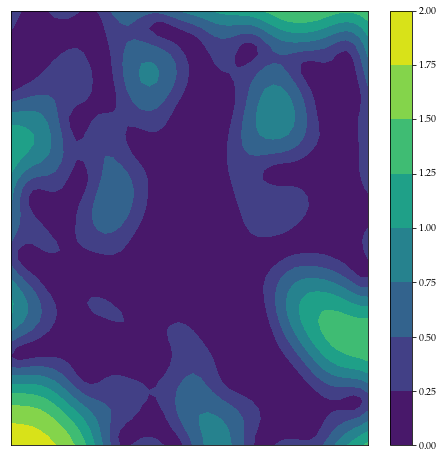

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
c = ax.contourf(x_plot[:, 0], x_plot[:, 1], u_plot.reshape((50, 50)))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('gpr-u', bbox_inches='tight', pad_inches=-0.1)

fig.colorbar(c, ax=ax)


In [26]:
api.test('rmse')

0.12501312684501634

(2500, 4)


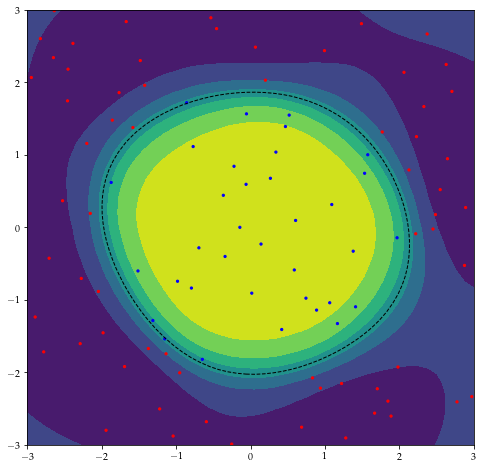

In [27]:
# Add classification example
api.init_classifier('gp')
api.classifier.fit(api.x_train_, api.t_train)
proba_grid, std_grid = api.classifier.predict(model_input_grid, return_std=True)

data = np.c_[x_to_save, proba_grid.ravel(), std_grid.ravel()]
np.savetxt('gpc-contour.csv', data, delimiter=',', comments='')
print(data.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
CS = ax.contour(x_plot[:, 0], x_plot[:, 1], proba_grid.reshape((50, 50)), levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax.contourf(x_plot[:, 0], x_plot[:, 1], proba_grid.reshape((50, 50)), levels=7)
# ax.contourf(x_plot[:, 0], x_plot[:, 1], proba_grid.reshape((50, 50)), levels=3)
ax.scatter(api.x[:, 0], api.x[:, 1], c=api.t, cmap='bwr_r', s=5)
# ax.clabel(CS, CS.levels, inline=True, fontsize=10)

headers = 'x1,x2'
np.savetxt('gpc-xtrain-con.csv', api.x_train[api.t_train.ravel() == 1, :], header=headers, delimiter=',', comments='')
np.savetxt('gpc-xtest-con.csv', api.x_test[api.t_test.ravel() == 1, :], header=headers, delimiter=',', comments='')
np.savetxt('gpc-xtrain-non.csv', api.x_train[api.t_train.ravel() == 0, :], header=headers, delimiter=',', comments='')
np.savetxt('gpc-xtest-non.csv', api.x_test[api.t_test.ravel() == 0, :], header=headers, delimiter=',', comments='')

plt.show()

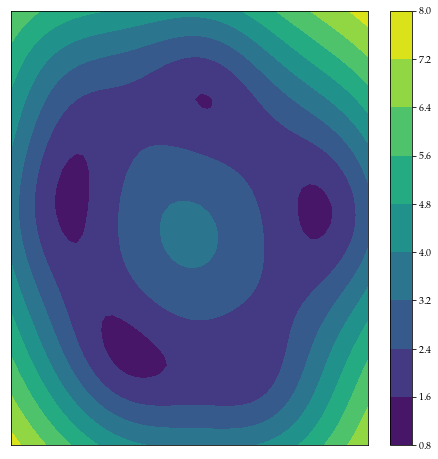

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# CS = ax.contour(x_plot[:, 0], x_plot[:, 1], proba_grid.reshape((50, 50)), levels=[0.25, 0.5, 0.75], linestyles='dashed', colors='k', linewidths=1)
c = ax.contourf(x_plot[:, 0], x_plot[:, 1], std_grid.reshape((50, 50)))
# ax.contourf(x_plot[:, 0], x_plot[:, 1], proba_grid.reshape((50, 50)), levels=3)
# ax.scatter(api.x[:, 0], api.x[:, 1], c=api.t, cmap='bwr_r', s=5)
# ax.clabel(CS, CS.levels, inline=True, fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig('gpc-u', bbox_inches='tight', pad_inches=-0.1)

fig.colorbar(c, ax=ax)
